# Assignment 1 — Colab Workflow (GitHub + Pre-commit + Submission Validation)

This notebook teaches the standard workflow used throughout the course:

1. Clone your team repo
2. Install dependencies
3. Install **pre-commit** and enable a hook to strip notebook outputs
4. Run this notebook end-to-end
5. Validate `predictions.csv`
6. Commit + push + tag


In [32]:
# (Colab) show python and system info
import sys, platform
print(sys.version)
print(platform.platform())


3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Linux-6.6.105+-x86_64-with-glibc2.35


## 1) Clone Repo

Login to your personal Github account, and make a fork of: https://github.com/TLKline/AIHC-5010-Winter-2026

Follow setup directions for working with a PAT in GitHub (30-second guide):

* Go to GitHub → Settings
* Developer settings
* Personal access tokens
* Choose:
  * Fine-Grained

You can clone using HTTPS.

Repo HTTPS URL (e.g., `https://github.com/TLKline/AIHC-5010-Winter-2026.git`)

In [33]:
# TODO: Change the following to your github repo path
repo_path = 'https://github.com/TLKline/AIHC-5010-Winter-2026.git'
!git clone {repo_path} student_repo

Cloning into 'student_repo'...
remote: Enumerating objects: 342, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 342 (delta 30), reused 25 (delta 25), pack-reused 309 (from 2)
Receiving objects: 100% (342/342), 9.57 MiB | 23.22 MiB/s, done.
Resolving deltas: 100% (157/157), done.


In [34]:
# Move into repo
%cd student_repo

# Repo git info
!git status

# Where are we?
print('----------')
print('We are at:')
!pwd


/content/student_repo/AIHC-5010-Winter-2026/student_repo/student_repo
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
----------
We are at:
/content/student_repo/AIHC-5010-Winter-2026/student_repo/student_repo


## 2) Install dependencies

This installs whatever is in `requirements.txt`.


In [35]:
!pip -q install -r Project-1/readmit30/requirements.txt

## 3) Enable pre-commit hook to strip notebook outputs

This prevents giant notebooks and reduces merge/diff pain.

One-time per clone:
- `pre-commit install`

After that, every `git commit` will strip outputs from `*.ipynb`.


In [36]:
!pip -q install pre-commit
!pre-commit install


pre-commit installed at .git/hooks/pre-commit


#MAINSTART

# 4) Submission Notebook (Template)

Replace the baseline model with your team’s approach.

In [37]:
import os
from pathlib import Path

TRAIN_PATH = os.environ.get("TRAIN_PATH", "Project-1/readmit30/scripts/data/public/train.csv")
DEV_PATH   = os.environ.get("DEV_PATH",   "Project-1/readmit30/scripts/data/public/dev.csv")
TEST_PATH  = os.environ.get("TEST_PATH",  "Project-1/readmit30/scripts/data/public/public_test.csv")
OUT_PATH   = os.environ.get("OUT_PATH",   "predictions.csv")

print("TRAIN_PATH:", TRAIN_PATH)
print("DEV_PATH:", DEV_PATH)
print("TEST_PATH:", TEST_PATH)
print("OUT_PATH:", OUT_PATH)

TRAIN_PATH: Project-1/readmit30/scripts/data/public/train.csv
DEV_PATH: Project-1/readmit30/scripts/data/public/dev.csv
TEST_PATH: Project-1/readmit30/scripts/data/public/public_test.csv
OUT_PATH: predictions.csv


In [38]:
import numpy as np
import pandas as pd
np.random.seed(42)

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

assert "row_id" in train.columns and "readmit30" in train.columns
assert "row_id" in test.columns

X_train = train.drop(columns=["readmit30"])
y_train = train["readmit30"].astype(int)

In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
# TODO: Add any new imports for your own method here
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder

method = 4

cat_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
num_cols = [c for c in X_train.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                          ("onehot", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
    ],
)

if method==1:
    # Use logistic regression model
    clf = Pipeline([
        ("preprocess", preprocess),
        ("model", LogisticRegression(max_iter=200)),
    ])

if method==2:
    # Use logistic regression model
    clf = Pipeline([
        ("preprocess", preprocess),
        ("model", LogisticRegression(max_iter=200,class_weight='balanced')),
    ])

if method==3:
    # Use SVC (i.e. SVM model)
    clf = Pipeline(
        [
            ("preprocess", preprocess),
            ("scaler", StandardScaler(with_mean=False)), # Add StandardScaler here
            ("model", SVC(gamma="auto",max_iter=1000,probability=True)),
        ]
    )

if method == 4:
    # Preprocess for HGB: ordinal-encode categories (HGB needs numeric inputs)
    preprocess_hgb = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
            ]), num_cols),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
            ]), cat_cols),
        ],
        remainder="drop",
    )

    clf = Pipeline([
        ("preprocess", preprocess_hgb),
        ("model", HistGradientBoostingClassifier(
            max_depth=6,
            learning_rate=0.05,
            max_iter=300,
            l2_regularization=1.0,
            early_stopping=True,
            random_state=42,
            class_weight='balanced',
        )),
    ])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['encounter_id',
                                                   'patient_nbr',
                                                   'admission_type_id',
                                                   'discharge_disposition_id',
                                                   'admission_source_id',
                                                   'time_in_hospital',
                                                   'num_lab_procedures',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emergency',
                                                   'numb...
                                                   'acetohexamide', 'glipizide',
                                                   'glyburide', 'tolbutamide',
                                                   'pioglitazone',
                                                   'rosiglitazone', 'acarbose',
                                                   'miglitol', 'troglitazone',
                                                   'tolazamide', 'examide',
                                                   'citoglipton', 'insulin',
                                                   'glyburide-metformin', ...])])),
                ('model',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                early_stopping=True,
                                                l2_regularization=1.0,
                                                learning_rate=0.05, max_depth=6,
                                                max_iter=300,
                                                random_state=42))])

In [40]:
p_test = clf.predict_proba(test)[:, 1]
pred = pd.DataFrame({"row_id": test["row_id"].astype(int), "prob_readmit30": p_test.astype(float)})
pred.to_csv(OUT_PATH, index=False)
pred.head()

,row_id,prob_readmit30
0,103521306,0.561462
1,127919112,0.704297
2,233245326,0.628062
3,236785056,0.317179
4,131110896,0.343137


In [41]:
# Validate output format (required for students before tagging)
!python Project-1/readmit30/scripts/validate_submission.py --pred {OUT_PATH} --test {TEST_PATH}


OK: predictions.csv format is valid.


AUROC: 0.6967
AUPRC: 0.2444
Brier Score: 0.2141


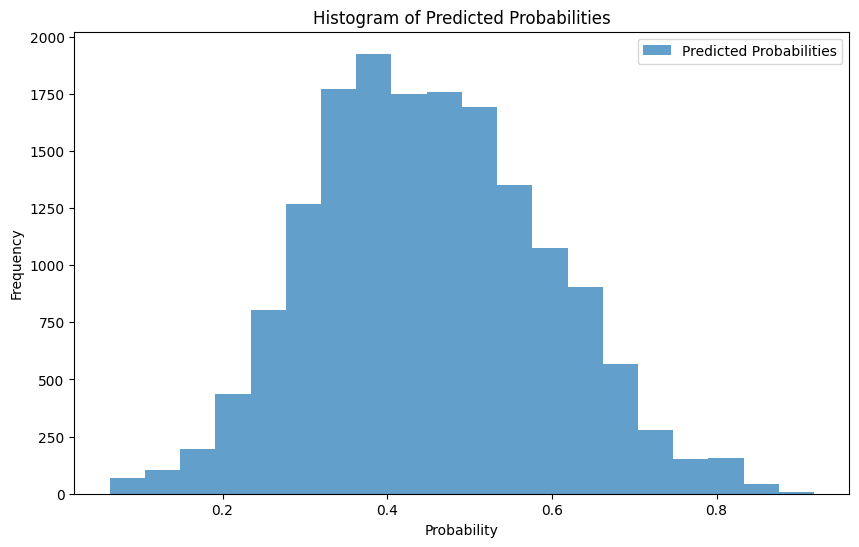

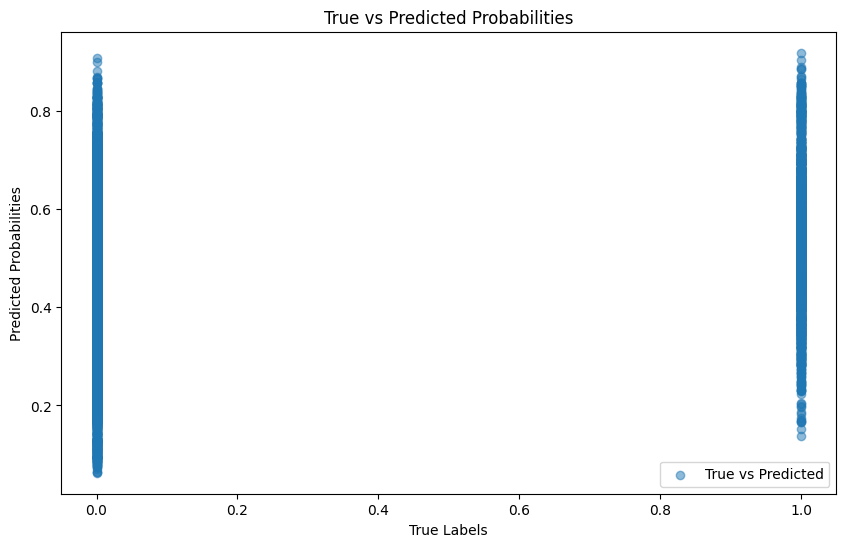

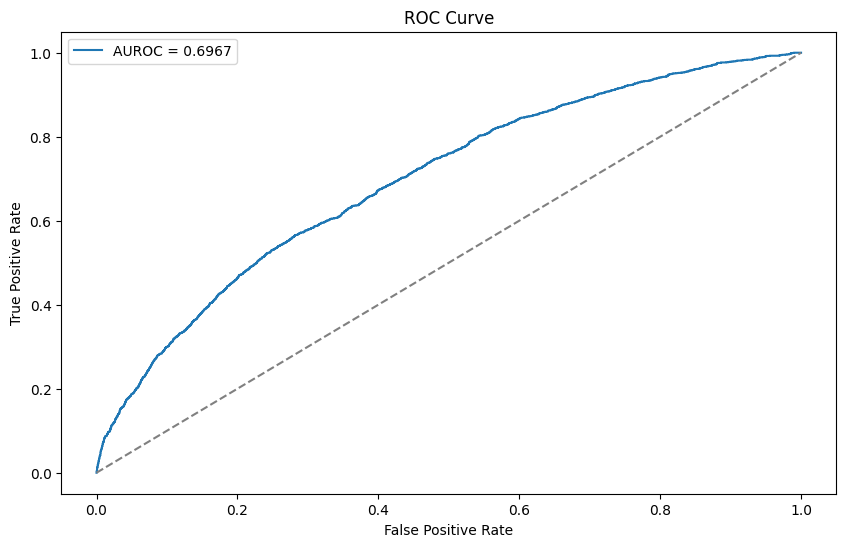

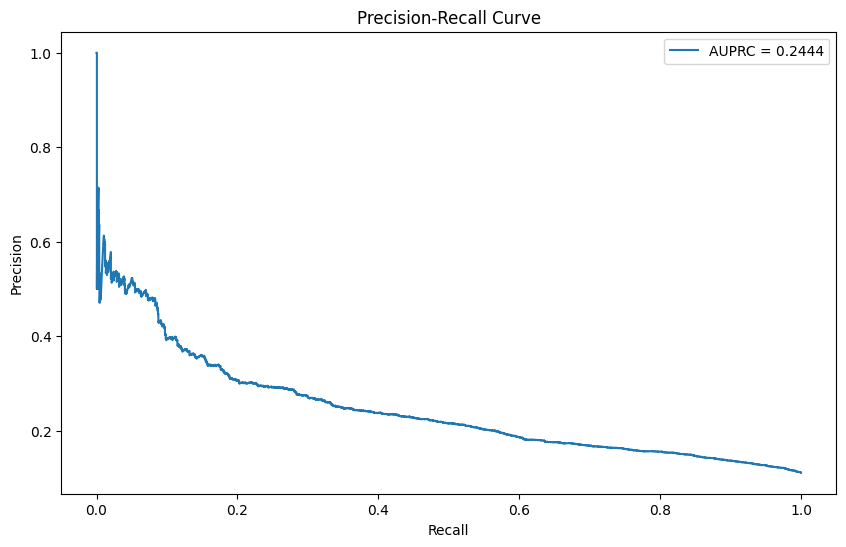

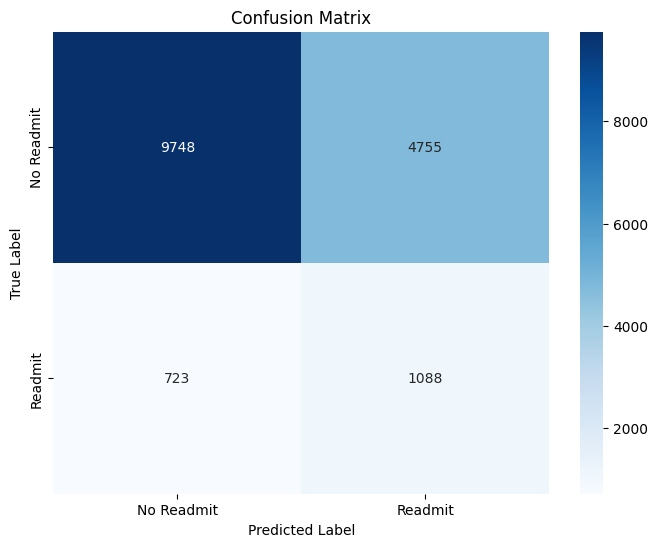

In [42]:
# Calculate metrics for the dev set
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
import matplotlib.pyplot as plt

dev = pd.read_csv(DEV_PATH)

X_dev = dev.drop(columns=["readmit30"])
y_dev = dev["readmit30"].astype(int)

# Calculate metrics
y_true = y_dev.astype(int)
y_pred = clf.predict_proba(X_dev)[:, 1]

auroc = roc_auc_score(y_true, y_pred)
auprc = average_precision_score(y_true, y_pred)
brier = brier_score_loss(y_true, y_pred)

print(f'AUROC: {auroc:.4f}')
print(f'AUPRC: {auprc:.4f}')
print(f'Brier Score: {brier:.4f}')

# Create figures
plt.figure(figsize=(10, 6))

# Histogram of predicted probabilities
plt.hist(y_pred, bins=20, alpha=0.7, label='Predicted Probabilities')
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Scatter plot of true vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5, label='True vs Predicted')
plt.title('True vs Predicted Probabilities')
plt.xlabel('True Labels')
plt.ylabel('Predicted Probabilities')
plt.legend()
plt.show()

# Create ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUROC = {auroc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Create Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'AUPRC = {auprc:.4f}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Create Confusion Matrix Heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns

threshold = 0.5  # Default threshold for binary classification
y_pred_binary = (y_pred >= threshold).astype(int)
cm = confusion_matrix(y_true, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Readmit', 'Readmit'], yticklabels=['No Readmit', 'Readmit'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#MAINEND

## 5) Validate the predictions file format

This checks:
- required columns
- probabilities in [0, 1]
- row_ids match the test file

It assumes the submission notebook wrote `predictions.csv` in the repo root.


In [43]:
from pathlib import Path
pred_path = Path("predictions.csv")
test_path = Path("Project-1/readmit30/scripts/data/public/public_test.csv")

if not pred_path.exists():
    print("predictions.csv not found. Run notebooks/submission.ipynb first.")
else:
    !python Project-1/readmit30/scripts/validate_submission.py --pred predictions.csv --test Project-1/readmit30/scripts/data/public/public_test.csv


OK: predictions.csv format is valid.


## 6) Commit + push + tag

You will:
- add changes
- commit (pre-commit hook runs here)
- push
- tag a milestone (example: `milestone_wk3`) and push tags



You will need a Personal Access Token (PAT) for the following step. See instructions above.

In [ ]:
# ==== Colab -> GitHub commit/push for a specific notebook path (PAT auth) ====
# What this does:
#  1) clones the repo into the Colab VM
#  2) overwrites the target notebook file with the *currently open* Colab notebook
#  3) commits the change
#  4) asks you for a GitHub PAT and pushes to the target branch
#  5) (optional) creates a git tag and pushes the tag
#
# Notes:
#  - PAT is read via getpass (not echoed). It is only used for this runtime session.
#  - This overwrites the file at TARGET_REL with the *current Colab notebook contents*.

import os
import json
import subprocess
import getpass
from google.colab import _message

# ==========================
# START USER-EDITABLE SETTINGS
# ==========================
# Repo settings
REPO_HTTPS = "https://github.com/TLKline/AIHC-5010-Winter-2026.git"  # full https clone URL ending in .git
REPO_DIR   = "AIHC-5010-Winter-2026"                                # folder name to clone into (or reuse)

# Git settings
BRANCH     = "main"                                                 # branch to commit/push to
COMMIT_MSG = "Update Assignment1_Colab_Workflow.ipynb from Colab test5"    # commit message

# File to overwrite inside the repo (relative to repo root)
TARGET_REL = "Project-1/readmit30/notebooks/Assignment1_Colab_Workflow.ipynb"

# Identity for commits
GIT_USER_NAME  = "Timothy Kline"
GIT_USER_EMAIL = "kline.timothy@mayo.edu"

# (Optional) If you want to push to a different remote than REPO_HTTPS, set it here.
# Leave as None to use REPO_HTTPS.
PUSH_REMOTE_HTTPS = None  # e.g. "https://github.com/<user>/<repo>.git"

# Set TAG_NAME to something like "assignment1-submission-v1".
# Leave as "" (empty string) to skip tagging.
TAG_NAME    = "assignment1-submission-v01"  # e.g. "assignment1-submission-v1"
TAG_MESSAGE = "Assignment 1 submission"  # used only for annotated tags
TAG_ANNOTATED = True  # True = annotated tag (-a -m). False = lightweight tag.
# ==========================
# END USER-EDITABLE SETTINGS
# ==========================


def run(cmd, cwd=None, check=True):
    """Run a shell command and stream output."""
    print(f"\n$ {' '.join(cmd)}")
    p = subprocess.run(cmd, cwd=cwd, text=True, capture_output=True)
    if p.stdout:
        print(p.stdout)
    if p.stderr:
        print(p.stderr)
    if check and p.returncode != 0:
        raise RuntimeError(f"Command failed with exit code {p.returncode}: {' '.join(cmd)}")
    return p


def github_authed_remote(https_remote: str, token: str) -> str:
    """
    Convert https://github.com/OWNER/REPO.git into https://TOKEN@github.com/OWNER/REPO.git
    Works for standard GitHub HTTPS remotes.
    """
    if https_remote.startswith("https://"):
        return "https://" + token + "@" + https_remote[len("https://"):]
    raise ValueError("Expected an https remote URL (starting with https://).")


def tag_exists_locally(tag_name: str, cwd: str) -> bool:
    p = subprocess.run(["git", "tag", "-l", tag_name], cwd=cwd, text=True, capture_output=True)
    return p.stdout.strip() == tag_name


REMOTE_FOR_PUSH = PUSH_REMOTE_HTTPS or REPO_HTTPS

# 1) Clone (or reuse existing clone)
if not os.path.isdir(REPO_DIR):
    run(["git", "clone", REPO_HTTPS, REPO_DIR])
else:
    print(f"Repo directory already exists: {REPO_DIR}")

# Ensure we're on the right branch and up-to-date
run(["git", "checkout", BRANCH], cwd=REPO_DIR)
run(["git", "pull", "origin", BRANCH], cwd=REPO_DIR)

# 2) Get the currently-open notebook JSON from Colab
nb = _message.blocking_request("get_ipynb", timeout_sec=30)["ipynb"]

# 3) Overwrite the target file in the clone
target_abs = os.path.join(os.getcwd(), REPO_DIR, TARGET_REL)
os.makedirs(os.path.dirname(target_abs), exist_ok=True)
with open(target_abs, "w", encoding="utf-8") as f:
    json.dump(nb, f, ensure_ascii=False, indent=1)

print("Wrote current Colab notebook to:")
print(" ", target_abs)

# 4) Configure git identity
run(["git", "config", "user.name", GIT_USER_NAME], cwd=REPO_DIR)
run(["git", "config", "user.email", GIT_USER_EMAIL], cwd=REPO_DIR)

# 5) Show status; if no changes, stop early
status = run(["git", "status", "--porcelain"], cwd=REPO_DIR, check=True).stdout.strip()
if not status:
    print("\nNo changes detected in the repo after writing the notebook.")
    print("Double-check that you're running this cell inside the notebook you edited,")
    print("and that TARGET_REL points to the correct path inside the repo.")
else:
    # 6) Add + commit
    run(["git", "add", TARGET_REL], cwd=REPO_DIR)

    commit_proc = subprocess.run(
        ["git", "commit", "-m", COMMIT_MSG],
        cwd=REPO_DIR, text=True, capture_output=True
    )
    if commit_proc.stdout:
        print(commit_proc.stdout)
    if commit_proc.stderr:
        print(commit_proc.stderr)

    combined = (commit_proc.stdout + commit_proc.stderr).lower()
    if commit_proc.returncode != 0 and "nothing to commit" not in combined:
        raise RuntimeError("git commit failed unexpectedly")

    # 7) Ask for PAT and push
    print("\nEnter a GitHub Personal Access Token (PAT) with permission to push to this repo.")
    print("Recommended: fine-grained token with access to the repo and Contents: Read/Write.")
    token = getpass.getpass("GitHub PAT (input hidden): ").strip()
    if not token:
        raise ValueError("No token entered.")

    # Temporarily set authenticated remote URL for this push only (and for tag push)
    authed_remote = github_authed_remote(REMOTE_FOR_PUSH, token)
    run(["git", "remote", "set-url", "origin", authed_remote], cwd=REPO_DIR)

    try:
        # Push commits
        run(["git", "push", "origin", BRANCH], cwd=REPO_DIR)
        print(f"\n Pushed successfully to {BRANCH}.")

        # 8) OPTIONAL: Create + push tag
        if TAG_NAME.strip():
            tag_name = TAG_NAME.strip()

            # If tag already exists locally, don't recreate
            if tag_exists_locally(tag_name, REPO_DIR):
                print(f"Tag already exists locally: {tag_name}")
            else:
                if TAG_ANNOTATED:
                    run(["git", "tag", "-a", tag_name, "-m", TAG_MESSAGE], cwd=REPO_DIR)
                else:
                    run(["git", "tag", tag_name], cwd=REPO_DIR)
                print(f"Created tag: {tag_name}")

            # Push just this tag (or use --tags to push all tags)
            run(["git", "push", "origin", tag_name], cwd=REPO_DIR)
            print(f" Pushed tag: {tag_name}")
        else:
            print("Skipping tag creation (TAG_NAME is empty).")

        print("\nDone. Check GitHub for the new commit (and tag, if set).")

    finally:
        # Restore remote URL without token
        run(["git", "remote", "set-url", "origin", REPO_HTTPS], cwd=REPO_DIR, check=False)



$ git clone https://github.com/TLKline/AIHC-5010-Winter-2026.git AIHC-5010-Winter-2026
Cloning into 'AIHC-5010-Winter-2026'...


$ git checkout main
Your branch is up to date with 'origin/main'.

Already on 'main'


$ git pull origin main


## Done ✅

If you hit issues:
- Make sure you pulled the latest course template (missing files).
- Make sure `data/public/*` exists in your repo (or your instructor provided it separately).
